# Computing theoretical densities
Theoretical probability density functions (pdfs) are a core feature, which allow you to explore a hypothesized aggregated Markov process. Pdfs can be used as a reference point to directly observe the convergence of observed histograms or to explore the assumed model beyond observable timescales. They are also a key ingredient in the later chapters of this tutorial.

## The classes
This chapter introduces the two main classes used to handle aggregated Markov processes:

1. ```Topology```
2. ```AggregatedMarkovProcess```
First we create an instance of the topology class, which is defined by an adjacency matrix of the associated graph and the number of open states $n_o$. This assumes that the first $n_o$ states (columns and rows of the matrix) correspond to the open states, with the other $n-n_o$ states being closed.

In [5]:
import numpy as np
from bonnpatch.core import generation
adj=np.array([[0,0,1,1,0],[0,0,0,0,1],[1,0,0,0,0],[1,0,0,0,1],[0,1,0,1,0]])
n_o=2
top=generation.Topology(adj,n_o,name="COCCO") # Defines the COCCO linear five state topology as an object. The name argument is optional.

We can now define an aggregated Markov process using a rate matrix $Q$ and the topology:

In [6]:
Q=10_000*np.array([[-0.80294985,0.0,0.40123272,0.40171713,0.0],[0.0,-0.01381559,0.0,0.0,0.01381559],[0.10448446,0.0,-0.10448446, 0.0, 0.0],[0.86417804, 0.0, 0.0, -0.95476492, 0.09058688],[0.0, 0.9441882, 0.0, 0.24489628, -1.18908448]])
Z=generation.AggregatedMarkovProcess(top,Q,lambda x: x<n_o)

Now that we have defined a process, we can easily plot the one and two dimensional dwell time distributions, using the method ```get_theroetical_densities```.
This method takes the important argument "mode", which dictates which analytical description of the densities. While mathematically equivalent, we can see that they differ numerically. Anecdotally the 
matrix exponential based approach is slower, but produces densities closer to the sampled histograms and is therefore preferred and the approach being used if no ```mode``` is given to the method.
For completeness the matrix exponential of the 2 dimensional dwell time distribution with density $f_oc$ has the following form {cite}`fredkin1985`:
```{math}
f_{oc}(t,s)=\pi_0e^{Q_{oo}t}Q_{oc}e^{Q_{cc}s}Q_{co}1_o
```
While the mixture of exponentials (```mode="expo"```) as this form:
```{math}
f_{oc}(t,s)=\sum_{i=1}^{n_o}\sum_{j=1}^{n_c} \alpha_{ij}e^{\lambda_i t+ \omega_j s}
```
To construct the appropriate functions all necessary coefficients are precomputed and reused on every evaluation of the densities.

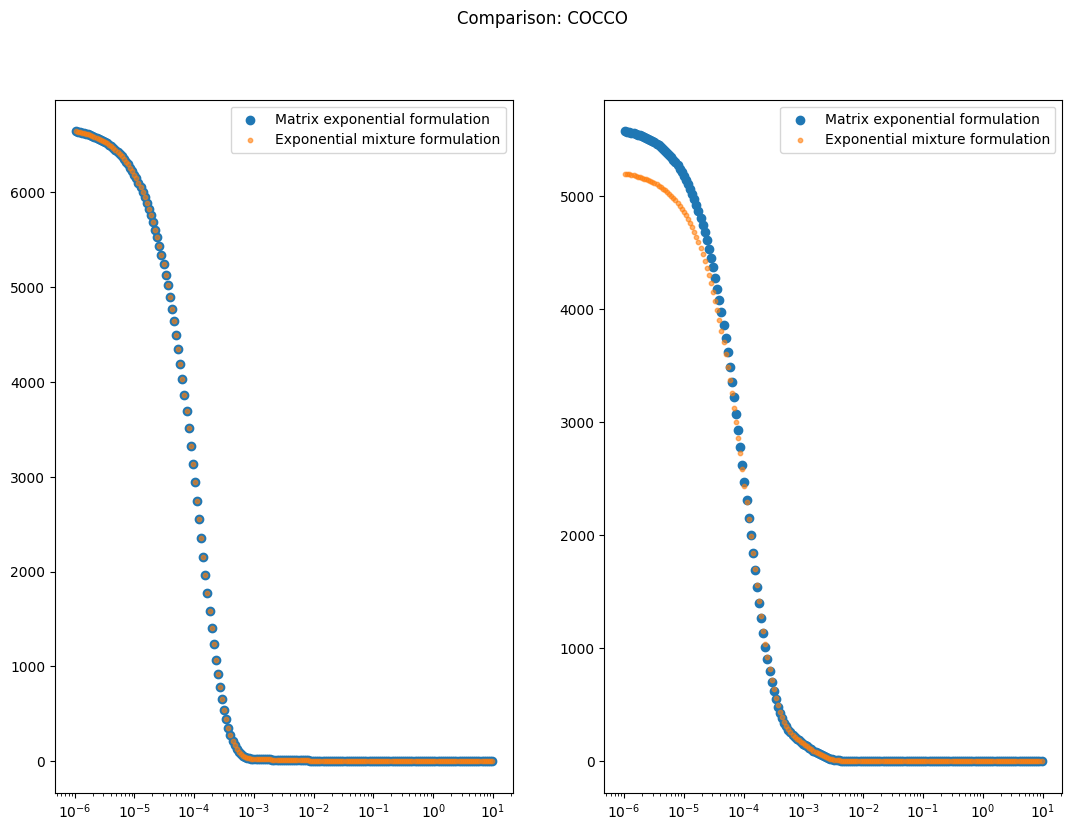

In [ ]:
import matplotlib.pyplot as plt 
bin_edges = np.logspace(-6, 1, num=201)

f_o_matrix,f_c_matrix,f_oc_matrix,f_co_matrix=Z.get_theoretical_densities(mode="matrixexpo")
f_o_exponential,f_c_exponential,f_oc_exponential,f_co_exponential=Z.get_theoretical_densities(mode="expo")
fig, axs = plt.subplots(1,2,figsize=(13, 9))
fig.suptitle(f"Comparison of 1D dwell time distributions: {Z._topology._name}")
density=np.diff(bin_edges)
ts = 0.5 * (bin_edges[:-1] + bin_edges[1:])
axs[0].scatter(ts,[f_o_matrix(t) for t in ts],label="Matrix exponential formulation")
axs[0].scatter(ts,[f_o_exponential(t) for t in ts],label="Exponential mixture formulation",s=10,alpha=0.6)
axs[0].set_xscale("log")
axs[0].legend()
axs[1].scatter(ts,[f_c_matrix(t) for t in ts],label="Matrix exponential formulation")
axs[1].scatter(ts,[f_c_exponential(t) for t in ts],label="Exponential mixture formulation",s=10,alpha=0.6)
axs[1].set_xscale("log")
axs[1].legend()
plt.legend()
plt.show()


The comparison for the two dimensional dwell time distribution will be done via some approximation of the expected histograms, since these are directly comparable to the observed data:

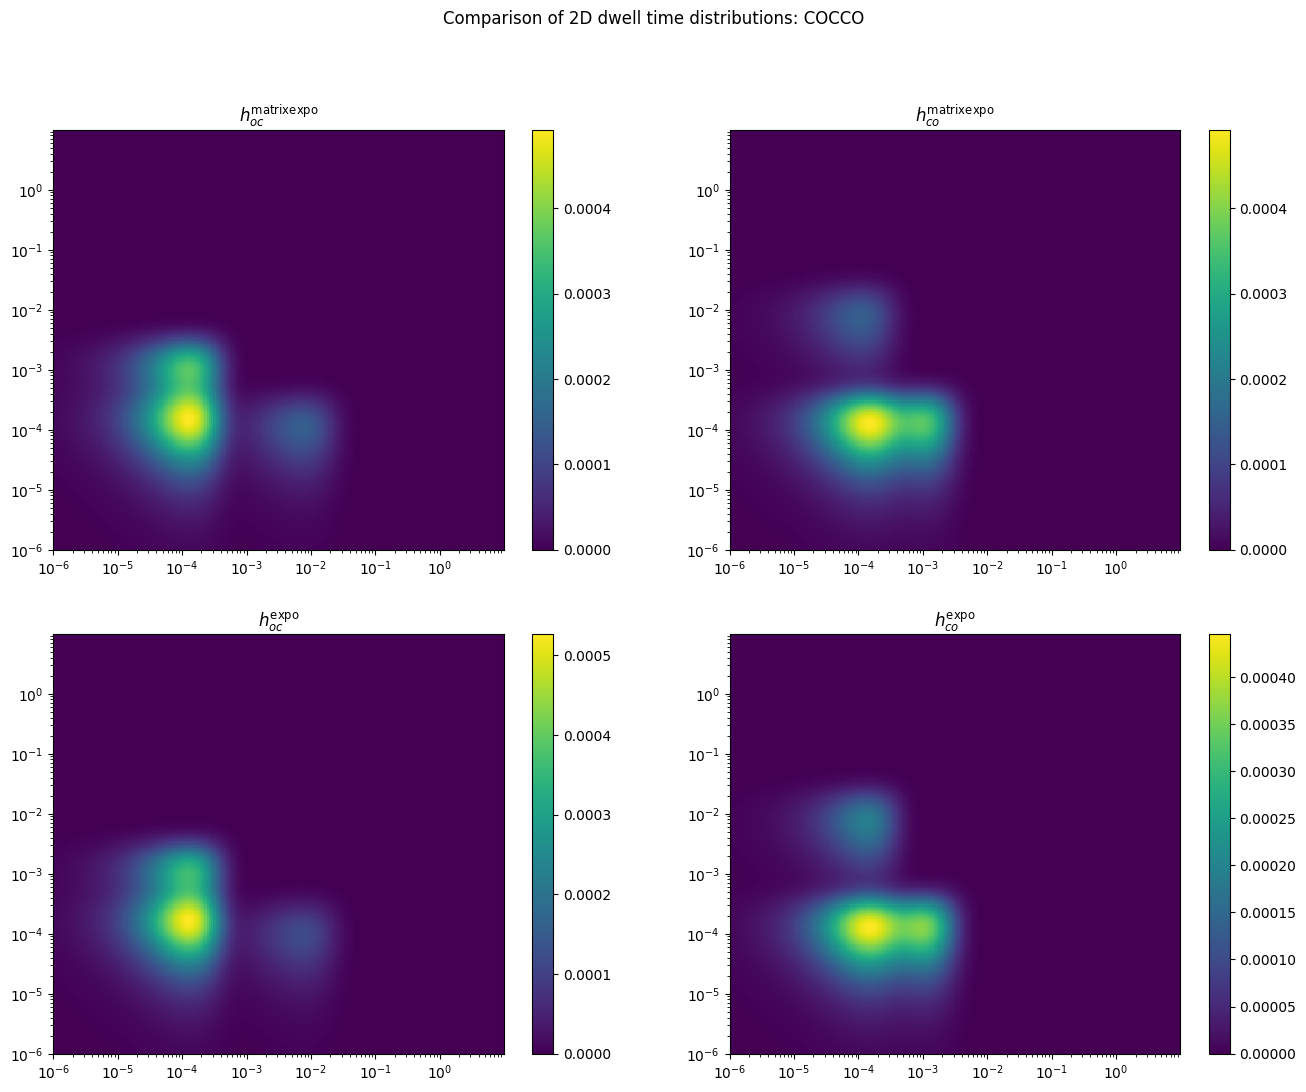

In [16]:
density=np.diff(bin_edges)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
theoretical_histogram_oc_matrix=np.array([[f_oc_matrix(t,s)*density[i]*density[j] for  i,t in enumerate(bin_centers)] for j,s in enumerate(bin_centers)]).astype(float)
theoretical_histogram_oc_exponential=np.array([[f_oc_exponential(t,s)*density[i]*density[j] for  i,t in enumerate(bin_centers)] for j,s in enumerate(bin_centers)]).astype(float)
theoretical_histogram_co_matrix=np.array([[f_co_matrix(s,t)*density[i]*density[j] for  j,s in enumerate(bin_centers)] for i,t in enumerate(bin_centers)]).astype(float)
theoretical_histogram_co_exponential=np.array([[f_co_exponential(s,t)*density[i]*density[j] for  j,s in enumerate(bin_centers)] for i,t in enumerate(bin_centers)]).astype(float)
fig, axs = plt.subplots(2,2,figsize=(16, 12))
title=f"Comparison of 2D dwell time distributions: {Z._topology._name}"
fig.suptitle(title)
axs[0,0].set_title(r"$h_{oc}^\text{matrixexpo}$")
axs[0,0].set_xscale("log")
axs[0,0].set_yscale("log")
pc1=axs[0,0].pcolormesh(bin_centers,bin_centers,theoretical_histogram_oc_matrix)
fig.colorbar(pc1)
axs[1,0].set_title(r"$h_{oc}^\text{expo}$")
axs[1,0].set_xscale("log")
axs[1,0].set_yscale("log")
pc2=axs[1,0].pcolormesh(bin_centers,bin_centers,theoretical_histogram_oc_exponential)
fig.colorbar(pc2)
axs[0,1].set_title(r"$h_{co}^\text{matrixexpo}$")
axs[0,1].set_xscale("log")
axs[0,1].set_yscale("log")
pc3=axs[0,1].pcolormesh(bin_centers,bin_centers,theoretical_histogram_co_matrix)
fig.colorbar(pc3)
axs[1,1].set_title(r"$h_{co}^\text{expo}$")
axs[1,1].set_xscale("log")
axs[1,1].set_yscale("log")
pc4=axs[1,1].pcolormesh(bin_centers,bin_centers,theoretical_histogram_co_exponential)
fig.colorbar(pc4)
plt.show()

## Bibliography
```{bibliography}
:style: alpha
:filter: docname in docnames
```